# Feature Engineering

This notebook explores feature transformations applied after preprocessing.
The goal is to evaluate how different representations of sensor data
affect model performance and suitability for different model families.

The focus of this notebook is post-imputation feature transformations that may improve model performance or stability. 
Feature selection decisions are not finalized here, but candidate transformations are evaluated for different model families.

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(PROJECT_ROOT)

from src.preprocessing import preprocess

train_df = pd.read_csv("../data/raw/aps_failure_training_set.csv", header=14)
test_df = pd.read_csv("../data/raw/aps_failure_test_set.csv", header=14)
X_train, y_train, imputer, indicator = preprocess(train_df, fit=True)
X_test, y_test, _, _ = preprocess(test_df, fit=False, imputer=imputer, indicator=indicator)


In [2]:
pd.Series(X_train.flatten()).describe()

count    2.034000e+07
mean     1.279740e+06
std      4.646660e+07
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      6.334850e+02
max      8.584298e+09
dtype: float64

## Scaling

Since the data's range goes over several magnitutes, it makes sense to scale the data and then use a PCA (Principal Component Analysis). PCA identifies orthogonal directions of maximal variance in the standardized feature space, allowing correlated or redundant features to be compressed into fewer components. This can lead to dimensionality reduction, which would reduce the cost of creating a model.

In [3]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled

array([[ 0.11938141, -0.0963075 ,  2.31022415, ..., -0.10634761,
        -0.21808069, -0.21803875],
       [-0.18069661, -0.0963075 , -0.43285895, ..., -0.10634761,
        -0.21808069, -0.21803875],
       [-0.12581066, -0.0963075 , -0.43285865, ..., -0.10634761,
        -0.21808069, -0.21803875],
       ...,
       [-0.40724039, -0.0963075 ,  2.31022414, ..., -0.10634761,
        -0.21808069, -0.21803875],
       [ 0.14409453, -0.0963075 ,  2.31022414, ..., -0.10634761,
        -0.21808069, -0.21803875],
       [-0.13143541, -0.0963075 , -0.43285805, ..., -0.10634761,
        -0.21808069, -0.21803875]], shape=(60000, 339))

Missingness indicators are included in the standardized feature matrix to allow PCA to capture joint variance patterns between sensor values and missingness. This choice favors predictive performance over interpretability for linear models.

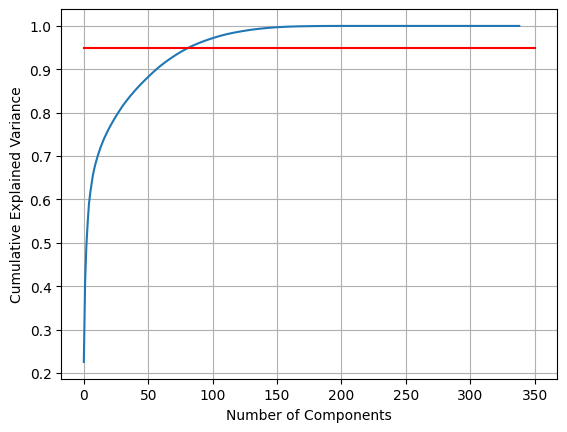

In [4]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.plot([0, 350], [0.95, 0.95], color='red')

ax = plt.gca()
ax.grid(True, which='major')
plt.show()


## PCA Observations

PCA shows that 95% of the cumulative explained variance can be retained using 83 components instead of the original 339 features. Hence it is possible to decrease the dimensionality drastically for linear models. This reduction is not applied to tree-based models, which can naturally handle high-dimensional feature spaces and benefit from explicit missingness indicators.

In [5]:
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
n_components_95


np.int64(83)

To be more precise, there are 83 features that are required to get a variance of 95% from the whole dataset.

In [8]:
pd.Series(pca.explained_variance_ratio_).head(10), pd.Series(pca.explained_variance_ratio_).describe()



(0    0.225653
 1    0.185074
 2    0.083644
 3    0.052545
 4    0.043500
 5    0.024820
 6    0.020842
 7    0.018962
 8    0.014634
 9    0.012171
 dtype: float64,
 count    3.390000e+02
 mean     2.949853e-03
 std      1.693897e-02
 min      0.000000e+00
 25%      1.155015e-18
 50%      6.018393e-05
 75%      1.379130e-03
 max      2.256529e-01
 dtype: float64)

## Feature Engineering conclusion
Two different datasets will be used for model development:
1. The full feature set (with missingness indicators, without PCA) for tree-based models
2. A standardized PCA-reduced feature set (83 components, retaining 95% variance) for linear models

Both representations will be evaluated empirically in the baseline modeling stage to assess their impact on predictive performance and cost.